----
**Helping Visually Impaired People to Identify Foods**

Master Ingeniería de Telecomunicación 2023-2024


Autor: Carlos González Gamella 100364132



----


**Con el modelo preentrenado se consigue 0.90727 de accuracy**

Conexión con Google Drive

In [1]:
# If you want to store some models or results into your drive, you might find these lines of code useful
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATVIAV/atviav-2324')

Mounted at /content/drive


#Importación de librerías

In [2]:
import pandas as pd
from PIL import Image

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

# Itertools
import itertools

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader,random_split
from torch.utils.data import sampler
from torch.utils.data import DataLoader, SubsetRandomSampler

import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import torch.backends.cudnn as cudnn

#1. Importación dataset

In [3]:
# Camino a la carpeta del dataset
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/ATVIAV/atviav-2324'

# Listar los archivos/directorios en la carpeta del dataset
os.listdir(path_to_dataset)

['test',
 'train',
 'googlenet_state.pth',
 'model_ft.pth',
 'submission_50.csv',
 'submission.csv']

In [4]:
# Cargar el conjunto de entrenamiento completo
full_train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/ATVIAV/atviav-2324/train')
clases = full_train_dataset.classes
print(clases)

# Dividir en conjunto de entrenamiento y validación
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Tamaños de los batches
batch_size = 64

# DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# DataLoader para el conjunto de validación
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']


#1.1 Transformaciones a las imágenes

Para poder sacar unos valores medios para estandarizar las imágenes

In [ ]:
'''
# Cargar el conjunto de datos sin normalización
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# Asegúrate de aplicar la transformación al cargar el conjunto de datos
full_train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/ATVIAV/atvaiv-2324/atvaiv_dataset/atvaiv_dataset/train', transform=transform)

# DataLoader
loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=64, shuffle=False, num_workers=2)

# Variables para almacenar sumas y conteos
mean = 0.
std = 0.
nb_samples = 0

for data, _ in loader:
    # Reajustar tamaño del batch
    batch_samples = data.size(0)

    # Reajustar datos para calcular la media y la std por canal
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

# Calcular la media y la std final
mean /= nb_samples
std /= nb_samples

# Imprimir los valores medios y desviaciones estándar por canal
print(f'Mean: {mean}')
print(f'Std: {std}')
'''

In [7]:
train_transforms = T.Compose([
    # Recortar la imagen de manera aleatoria y luego redimensionar a 224x224
    T.RandomResizedCrop(224),
    # Aplicar volteo horizontal y vertical de manera aleatoria
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    # Rotar la imagen un ángulo aleatorio entre 30 y 70 grados
    T.RandomRotation(degrees=(30, 70)),
    # Convertir la imagen a tensor
    T.ToTensor(),
    # Normalizar con los valores medios y desviaciones estándar de los datos
    T.Normalize((0.5600, 0.4481, 0.3405), (0.2248, 0.2356, 0.2332))
])

# Aplicar las transformaciones al conjunto de entrenamiento y test
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = train_transforms


# 1.2 Modelo from scracth basado en AlexNet

In [8]:
def flatten(x):
    N = x.shape[0]  # Lee N, C, H, W
    return x.view(N, -1)  # "Aplana" los valores C * H * W en un único vector por imagen

class AlexNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(AlexNet, self).__init__()
        self.c1 = nn.Conv2d(in_channel, 96, kernel_size=11, stride=4, padding=2)
        self.m1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.c2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.m2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.c3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.c4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.c5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.m3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fcout = nn.Linear(4096, num_classes)

    def forward(self, x):
        out = self.c1(x)
        out = F.relu(out)
        out = self.m1(out)

        out = self.c2(out)
        out = F.relu(out)
        out = self.m2(out)

        out = self.c3(out)
        out = F.relu(out)
        out = self.c4(out)
        out = F.relu(out)
        out = self.c5(out)
        out = F.relu(out)
        out = self.m3(out)

        out = flatten(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)

        out = self.fcout(out)

        return out

def test_AlexNet():
    x = torch.randn((64, 3, 224, 224))  # minibatch size 64, image size [3, 224, 224]
    model = AlexNet(in_channel=3, num_classes=11)
    scores = model(x)
    print("Output size:", scores.size())

test_AlexNet()


Output size: torch.Size([64, 11])


# Entrenando el modelo scratch

Para evaluar sobre los datos de eval

In [9]:
def eval_model(loader, model, device = torch.device('cuda')):
    loss = []
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad(): #normalmente uso modelo de descenso por gradiente, haciendo eso hago que no modifique ningún peso
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x) # saca las probabilidades de cada clase
            loss.append(F.cross_entropy(scores, y).data.cpu().numpy())
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        mean_loss = np.mean(loss)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Loss=%.2f' % mean_loss)
    return acc, mean_loss

In [10]:
def training_loop_plot(model, optimizer, epochs=1, device = torch.device('cuda')):
    ##############################################################
    # - - - WRITE YOUR CODE HERE - - -
    # 1) Modify the function 'training_loop' to represent,
    # using Matplotlib, the value of the loss for the training
    # and validation sets over epochs.

    ##############################################################
    loss_val_list = []
    loss_train_list = []

    meanloss_val_list = []
    meanloss_train_list = []

    model.to(device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = nn.CrossEntropyLoss()
            loss = loss(scores, y) ### TO COMPLETE [COMPLETED]

            loss_train_list.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        # Save mean_loss values for each epoch
        meanloss_train_list.append(np.mean(loss_train_list))

        acc, mean_loss = eval_model(val_loader, model)
        meanloss_val_list.append(mean_loss)

    # Plot mean loss for each epoch and set
    plt.plot(loss_val_list)
    plt.plot(meanloss_train_list, label='Train')
    plt.plot(meanloss_val_list, label='Validation')
    plt.legend(title = 'Data')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Mean Loss over Epochs")
    plt.show()

Entrenando con tasa de aprendizaje: 0.015
Got 126 / 1315 correct (9.58)
Loss=2.40
Got 163 / 1315 correct (12.40)
Loss=2.40
Got 160 / 1315 correct (12.17)
Loss=2.40
Got 153 / 1315 correct (11.63)
Loss=2.40
Got 161 / 1315 correct (12.24)
Loss=2.40
Got 194 / 1315 correct (14.75)
Loss=2.39
Got 178 / 1315 correct (13.54)
Loss=2.37
Got 200 / 1315 correct (15.21)
Loss=2.31
Got 163 / 1315 correct (12.40)
Loss=2.38
Got 184 / 1315 correct (13.99)
Loss=2.37
Got 194 / 1315 correct (14.75)
Loss=2.31
Got 200 / 1315 correct (15.21)
Loss=2.28


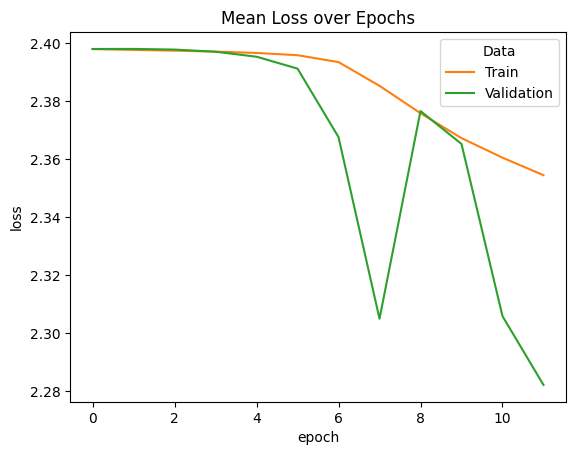

In [16]:
# Llamada a la función de entrenamiento con diferentes tasas de aprendizaje
lr = 0.015
num_epochs = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciando el modelo para cada tasa de aprendizaje
model_AlexNet = AlexNet(in_channel=3, num_classes=11).to(device)

# Definición del optimizador con la tasa de aprendizaje actual
optimizer = optim.SGD(model_AlexNet.parameters(), lr=lr)

# Llamada a la función de entrenamiento
print(f"Entrenando con tasa de aprendizaje: {lr}")
training_loop_plot(model_AlexNet, optimizer, num_epochs, device)


# Evaluando el modelo sobre los datos de test
Aplico las mismas transformaciones que al conjunto de datos de entrenamiento

In [7]:
#tranformaciones de las imagenes de test
transform_test = T.Compose([
    # Recortar la imagen de manera aleatoria y luego redimensionar a 224x224
    T.RandomResizedCrop(224),

    # Aplicar volteo horizontal y vertical de manera aleatoria
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    # Rotar la imagen un ángulo aleatorio entre 30 y 70 grados
    T.RandomRotation(degrees=(30, 70)),
    # Convertir la imagen a tensor
    T.ToTensor(),
    # Normalizar con los valores medios y desviaciones estándar de los datos
    T.Normalize((0.5600, 0.4481, 0.3405), (0.2248, 0.2356, 0.2332))
])

#funcion para crear un Dataset de los datos de test que no estan etiquetados
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.ids = sorted([int(file[0:-4]) for file in os.listdir(img_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        path = self.img_dir + '/' + str(self.ids[idx]) + '.jpg'
        image = Image.open(path)
        if self.transform:
            image = self.transform(image)
        return image

def etiq_model(loader, model, device):
    model.eval()  # Configurar el modelo en modo de evaluación
    preds = []
    with torch.no_grad():
        for x in loader:
            x = x.to(device=device, dtype=torch.float32)
            scores = model(x)
            _, batch_preds = scores.max(1)
            preds.extend(batch_preds.cpu().numpy())  # Acumular las predicciones
    return preds

In [8]:
test_dataset = ImageDataset(img_dir='/content/drive/MyDrive/Colab Notebooks/ATVIAV/atviav-2324/test',transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Configurar el dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_AlexNet.to(device)

# Obtener las predicciones
preds = etiq_model(test_loader, model_AlexNet, device)

In [15]:
submission_df = pd.DataFrame({
    'Id': test_dataset.ids,
    'Predicted': preds
})
submission_df.to_csv('submission.csv', index=False)


Guardando fichero a subir a KAGGLE:

In [18]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. MODELOS PREENTRENADOS

In [5]:
train_transforms = T.Compose([
    # Recortar la imagen de manera aleatoria y luego redimensionar a 224x224
    T.RandomResizedCrop(224),
    # Aplicar volteo horizontal y vertical de manera aleatoria
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    # Rotar la imagen un ángulo aleatorio entre 30 y 70 grados
    T.RandomRotation(degrees=(30, 70)),
    # Ajusta el brillo, el contraste, la saturación y el tono de manera aleatoria
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Convertir la imagen a tensor
    T.ToTensor(),
    # Normalizar con los valores medios y desviaciones estándar del full_dataset
    T.Normalize((0.5600, 0.4481, 0.3405), (0.2248, 0.2356, 0.2332))
])
val_transforms = T.Compose([
    # Recortar la imagen de manera aleatoria y luego redimensionar a 224x224
    T.RandomResizedCrop(224),
    # Convertir la imagen a tensor
    T.ToTensor(),
    # Normalizar con los valores medios y desviaciones estándar del full_dataset
    T.Normalize((0.5600, 0.4481, 0.3405), (0.2248, 0.2356, 0.2332))
])

# Aplicar las transformaciones al conjunto de entrenamiento y validación
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

#Entrenamos el modelo con los datos de train y validamos para ver los resultados obtenidos.
#Usamos el transformer vit_b_16.

In [6]:
cudnn.benchmark = True
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Entreno el modelo con los datos de train
model_ft = models.vit_b_16(pretrained=True)
num_ftrs = model_ft.num_classes
model_ft.fc = nn.Linear(num_ftrs, 11)
model_ft = model_ft.to(device)

# Mover el modelo al dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 139MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [7]:
# Ajustar la tasa de aprendizaje inicial si es necesario
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
# Usar un programador de tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.05)

criterion = nn.CrossEntropyLoss()

In [8]:
num_epochs = 15

for epoch in range(num_epochs):
    model_ft.train()  # Configurar en modo de entrenamiento
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Época {epoch+1}/{num_epochs}, Pérdida: {running_loss/len(train_loader)}')

    scheduler.step()

    # Validación
    model_ft.eval()  # Configurar en modo de evaluación
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Precisión en el conjunto de validación: {accuracy}%')

Época 1/15, Pérdida: 1.2730564054954483
Precisión en el conjunto de validación: 78.85931558935361%
Época 2/15, Pérdida: 0.5082883719938347
Precisión en el conjunto de validación: 80.22813688212928%
Época 3/15, Pérdida: 0.40183511421263934
Precisión en el conjunto de validación: 84.18250950570342%
Época 4/15, Pérdida: 0.3560065468212208
Precisión en el conjunto de validación: 83.95437262357414%
Época 5/15, Pérdida: 0.2941024025161582
Precisión en el conjunto de validación: 86.31178707224335%
Época 6/15, Pérdida: 0.30793624505939254
Precisión en el conjunto de validación: 83.8022813688213%
Época 7/15, Pérdida: 0.24829727572848997
Precisión en el conjunto de validación: 83.8022813688213%
Época 8/15, Pérdida: 0.17634002249463496
Precisión en el conjunto de validación: 86.08365019011407%
Época 9/15, Pérdida: 0.13880248373396784
Precisión en el conjunto de validación: 87.68060836501901%
Época 10/15, Pérdida: 0.11685153229319188
Precisión en el conjunto de validación: 87.90874524714829%
Época

Para guardar el modelo:

In [9]:
torch.save(model_ft.state_dict(), 'model_ft.pth')

Para cargar el modelo:

In [10]:
model_ft.load_state_dict(torch.load('model_ft.pth'))
model_ft.eval()


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [11]:
#tranformaciones de las imagenes de test
transform_test = T.Compose([
    # Recortar la imagen de manera aleatoria y luego redimensionar a 224x224
    T.RandomResizedCrop(224),
    T.ToTensor(),
    # Normalizar con los valores medios y desviaciones estándar del full_dataset
    T.Normalize((0.5600, 0.4481, 0.3405), (0.2248, 0.2356, 0.2332))])

#funcion para crear un Dataset de los datos de test que no estan etiquetados
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.ids = sorted([int(file[0:-4]) for file in os.listdir(img_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        path = self.img_dir + '/' + str(self.ids[idx]) + '.jpg'
        image = Image.open(path)
        if self.transform:
            image = self.transform(image)
        return image

def etiq_model(loader, model, device):
    model.eval()  # Configurar el modelo en modo de evaluación
    preds = []
    with torch.no_grad():
        for x in loader:
            x = x.to(device=device, dtype=torch.float32)
            scores = model(x)
            _, batch_preds = scores.max(1)
            preds.extend(batch_preds.cpu().numpy())  # Acumular las predicciones
    return preds

In [12]:
#Aplico la misma normalización que uso en el conjunto de datos de val
test_dataset = ImageDataset(img_dir='/content/drive/MyDrive/Colab Notebooks/ATVIAV/atviav-2324/test',transform=transform_test)
batch_size = 64 #numero total de imagenes de test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Configurar el dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.to(device)  # Asegúrate de que el modelo esté en el dispositivo correcto

# Obtener las predicciones
preds = etiq_model(test_loader, model_ft, device)

In [13]:
submission_df = pd.DataFrame({
    'Id': test_dataset.ids,
    'Predicted': preds
})
submission_df.to_csv('submission_50.csv', index=False)


Guardando fichero a subir a KAGGLE:




In [14]:
from google.colab import files
files.download('submission_50.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>